# Fake News Challenge -- two steps


First model -- related/unrelated

Second model -- agree/disagree/discuss

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn
plt.style.use('ggplot')

%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score

import warnings
warnings.filterwarnings('ignore')

import re
import string
from collections import defaultdict
from collections import Counter

# NLTK for NLP tools such as stemming, lemmatizing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop = set(stopwords.words('english'))

# import gensim
# from tqdm.notebook import tqdm

from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\peggy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\peggy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\peggy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\peggy\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Preprocess data

### load dataset/preprocess

In [2]:
train_bodies = pd.read_csv("C:/Users/peggy/Downloads/NLA_assignment/dataset/train_bodies.csv", encoding='utf-8')
train_stances = pd.read_csv("C:/Users/peggy/Downloads/NLA_assignment/dataset/train_stances.csv", encoding='utf-8')

### replace the stance with numbers
unrelated=0 ; agree=1 ; disagree=2 ; discuss=3

In [3]:
train_data = pd.merge(train_bodies, train_stances, how='left', on='Body ID')
stances = {
    'Stance': {'unrelated':0, 'agree': 1, 'disagree': 2, 'discuss': 3}
}
train_data.replace(stances, inplace=True)
train_data.drop('Body ID', axis=1)

,articleBody,Headline,Stance
0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",0
1,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,0
2,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,0
3,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,0
4,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,0
...,...,...,...
49967,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets tipped more than $2,00...",1
49968,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets $2,000 tip",1
49969,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip",1
49970,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...,1


### resample the dataset
unrelated=36545 ; agree=3678 ; disagree=840 ; discuss=8909

In [4]:
from sklearn.utils import resample
data_length = 8909
seed = 123
unrelated_resampled = resample(train_data.loc[train_data['Stance'] == 0], replace = False, n_samples = data_length, random_state = seed)
discuss_resampled = resample(train_data.loc[train_data['Stance'] == 3], replace = False, n_samples = data_length, random_state = seed)
agree_resampled = resample(train_data.loc[train_data['Stance'] == 1], replace=True, n_samples=data_length, random_state = seed)
disagree_resampled = resample(train_data.loc[train_data['Stance'] == 2], replace=True, n_samples=data_length, random_state = seed)

In [5]:
all_resampled = [unrelated_resampled, discuss_resampled, agree_resampled, disagree_resampled]
train_data_resampled = pd.concat(all_resampled)

In [6]:
new_stance = train_data_resampled['Stance']
train_data_resampled['new_stance'] = new_stance

In [7]:
mappings = {0:0 , 1:1 , 2:1 , 3:1}
train_data_resampled['Stance'] = train_data_resampled['Stance'].replace(mappings)

### clean data

In [8]:
# Relevant columns for this dataset
HEADLINE_COLUMN = 'Headline'
STANCE_COLUMN = 'Stance'
BODY_COLUMN = 'articleBody'

In [9]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub('', text)

train_data_resampled[BODY_COLUMN] = train_data_resampled[BODY_COLUMN].astype(str).apply(lambda x: remove_URL(x))
train_data_resampled[HEADLINE_COLUMN] = train_data_resampled[HEADLINE_COLUMN].astype(str).apply(lambda x: remove_URL(x))

In [10]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub('', text)

train_data_resampled[BODY_COLUMN] = train_data_resampled[BODY_COLUMN].apply(lambda x: remove_html(x))
train_data_resampled[HEADLINE_COLUMN] = train_data_resampled[HEADLINE_COLUMN].apply(lambda x: remove_html(x))

In [11]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

train_data_resampled[BODY_COLUMN] = train_data_resampled[BODY_COLUMN].apply(lambda x: remove_emoji(x))
train_data_resampled[HEADLINE_COLUMN] = train_data_resampled[HEADLINE_COLUMN].apply(lambda x: remove_emoji(x))

In [12]:
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

train_data_resampled[BODY_COLUMN] = train_data_resampled[BODY_COLUMN].apply(lambda x: remove_punct(x))
train_data_resampled[HEADLINE_COLUMN] = train_data_resampled[HEADLINE_COLUMN].apply(lambda x: remove_punct(x))

### Lemmetization

In [13]:
wnl = WordNetLemmatizer()

def lemmatize_sentence(sentence):
    sentence_words = sentence.split(' ')
    new_sentence_words = list()
    
    for sentence_word in sentence_words:
        sentence_word = sentence_word.replace('#', '')
        new_sentence_word = wnl.lemmatize(sentence_word.lower(), wordnet.VERB)
        new_sentence_words.append(new_sentence_word)
        
    new_sentence = ' '.join(new_sentence_words)
    new_sentence = new_sentence.strip()
    
    return new_sentence

train_data_resampled[BODY_COLUMN] = train_data_resampled[BODY_COLUMN].astype(str).apply(lambda x: lemmatize_sentence(x))
train_data_resampled[HEADLINE_COLUMN] = train_data_resampled[HEADLINE_COLUMN].astype(str).apply(lambda x: lemmatize_sentence(x))

### tokenize

In [14]:
train_data_resampled[BODY_COLUMN] = train_data_resampled[BODY_COLUMN].astype(str).apply(word_tokenize)
train_data_resampled[HEADLINE_COLUMN] = train_data_resampled[HEADLINE_COLUMN].astype(str).apply(word_tokenize)

In [15]:
train_data_resampled['text'] = train_data_resampled['articleBody'].astype(str) + ' ' + train_data_resampled['Headline'].astype(str)
train_data = train_data_resampled.drop(columns=['articleBody', 'Headline'])

### Feature extraction (tf-idf)

In [20]:
# train_text = train_data['text']
labels = train_data['Stance']

In [16]:
tfidf_vectorizer = TfidfVectorizer(decode_error='ignore', lowercase=True, min_df=2)
tfidf_vectorizer.fit(train_data['text'].values.astype('U'))

TfidfVectorizer(decode_error='ignore', min_df=2)

In [23]:
X = tfidf_vectorizer.transform(train_data['text'].values.astype('U'))

### split the data into train, test and validation data

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.20, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=seed)

## First model -- related/unrelated

In [25]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: numpy in c:\users\peggy\anaconda3\lib\site-packages (from xgboost) (1.19.5)



In [26]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
print("Train score:", xgb.score(X_train, y_train))
print("Validation score:", xgb.score(X_val, y_val))

Train score: 0.97676050162238
Validation score: 0.9430024552788495


In [27]:
from sklearn.metrics import accuracy_score

first_predict = xgb.predict(X_test)
accuracy = accuracy_score(y_test, first_predict)

print("test accuracy score:", accuracy)

test accuracy score: 0.9492143658810326


In [28]:
# Create the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10}) # font size
    plt.show()

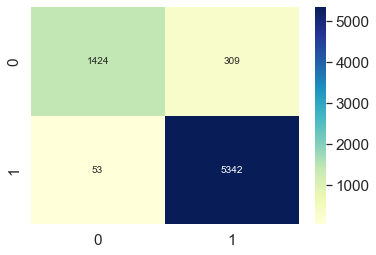

In [29]:
plot_confusion_matrix(y_test, np.round(first_predict))

## Second Model -- Agree/Disagree/Discuss

In [17]:
df = train_data[train_data['Stance'] != 0]

In [18]:
mappings = {1:0 , 2:1 , 3:2}
new_labels = df['new_stance'].replace(mappings)

In [19]:
new_X = tfidf_vectorizer.transform(df['text'].values.astype('U'))

In [20]:
X_train_sec, X_test_sec, y_train_sec, y_test_sec = train_test_split(new_X, new_labels, test_size=0.20, random_state=seed)
X_train_sec, X_val_sec, y_train_sec, y_val_sec = train_test_split(X_train_sec, y_train_sec, test_size=0.20, random_state=seed)

In [21]:
X_train_sec = X_train_sec.toarray()
X_val_sec = X_val_sec.toarray()
X_test_sec = X_test_sec.toarray()

In [22]:
from keras.utils.np_utils import to_categorical

num_classes = 3
y_train_sec_encoded = to_categorical(y_train_sec, num_classes)
y_val_sec_encoded = to_categorical(y_val_sec, num_classes)
y_test_sec_encoded = to_categorical(y_test_sec, num_classes)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

model_MLP = Sequential()
model_MLP.add(Dense(64, activation='relu', input_shape=(X_train_sec.shape[1],)))
model_MLP.add(Dropout(0.4))
model_MLP.add(Dense(64, activation='relu'))
model_MLP.add(Dropout(0.4))
model_MLP.add(Dense(64, activation='relu'))
model_MLP.add(Dropout(0.4))
model_MLP.add(Dense(3, activation='softmax'))
model_MLP.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


history = model_MLP.fit(X_train_sec, y_train_sec_encoded, validation_data=(X_val_sec, y_val_sec_encoded), epochs=50, batch_size=32, shuffle=True)

Epoch 1/50
535/535 [==============================] - 14s 25ms/step - loss: 0.6679 - accuracy: 0.7264 - val_loss: 0.4605 - val_accuracy: 0.8132
Epoch 2/50
535/535 [==============================] - 12s 22ms/step - loss: 0.4566 - accuracy: 0.8255 - val_loss: 0.4241 - val_accuracy: 0.8328
Epoch 3/50
535/535 [==============================] - 8s 14ms/step - loss: 0.4171 - accuracy: 0.8337 - val_loss: 0.4082 - val_accuracy: 0.8391
Epoch 4/50
535/535 [==============================] - 8s 15ms/step - loss: 0.3973 - accuracy: 0.8454 - val_loss: 0.4050 - val_accuracy: 0.8370
Epoch 5/50
535/535 [==============================] - 8s 15ms/step - loss: 0.3883 - accuracy: 0.8458 - val_loss: 0.3945 - val_accuracy: 0.8448
Epoch 6/50
535/535 [==============================] - 7s 14ms/step - loss: 0.3711 - accuracy: 0.8506 - val_loss: 0.3959 - val_accuracy: 0.8462
Epoch 7/50
535/535 [==============================] - 6s 12ms/step - loss: 0.3636 - accuracy: 0.8553 - val_loss: 0.3853 - val_accuracy: 0.85

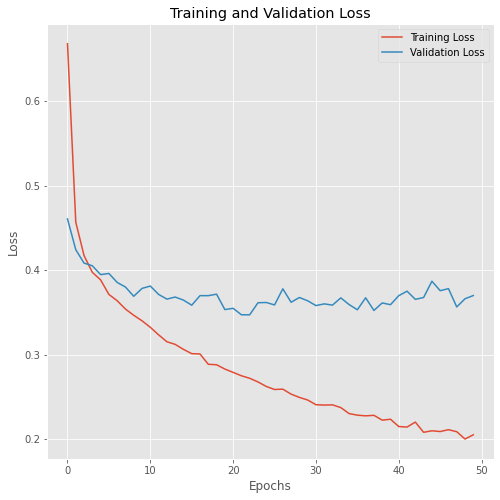

In [33]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

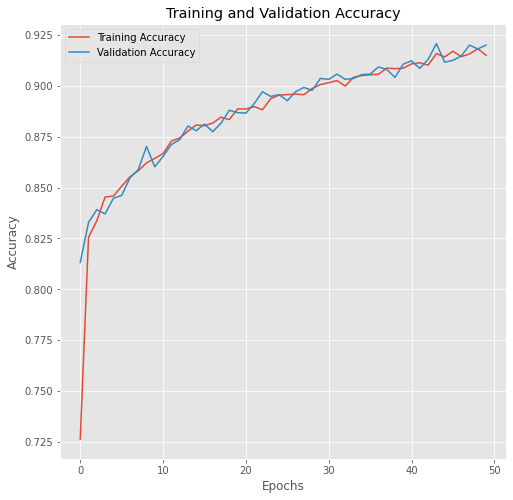

In [34]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
# Assuming you have a test dataset called X_test_sec and y_test_sec_encoded
test_loss, test_accuracy = model_MLP.evaluate(X_test_sec, y_test_sec_encoded)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

168/168 [==============================] - 3s 16ms/step - loss: 0.3378 - accuracy: 0.9231
Test Loss: 0.3378
Test Accuracy: 0.9231
